In [1]:
# Citibike 2019 project, analyzing 2018 date of service trip data
# Author: George Chan, Sean Guo

In [2]:
# Import library and modules
import pandas as pd
import glob
import numpy as np
import os
from datetime import timedelta
import matplotlib
import pickle

# Future use
# https://markhneedham.com/blog/2018/09/18/matplotlib-remove-axis-legend/

In [3]:
# Define where are the citibke 2018 zipfiles
data_folder = r'./Data/'
print('The data are stored in: ' + data_folder)

The data are stored in: ./Data/


In [4]:
# Check what are the files in that folder
for folderName, subfolders, filenames in os.walk(data_folder):
    print('Here are the list of csv zip files you have downloaded.\n')
    print(folderName)
    
    number_of_csv_file = 0 # Total count of files read
    all_files = []         # List of file path string
    
    # Reference 01: How to get index within for loop?
    # Reference 02: How to pad number with leading zeros?
    for filename in filenames:
        
        # If and only if they are csv files
        if filename.endswith('.csv'):
            number_of_csv_file += 1
            
            # Print to terminal to show user what files is found
            print('\t' + str(number_of_csv_file).zfill(2) + ': ' + filename)
            all_files.append(data_folder + filename)
            
    # all_files = all_files.sort()
            
    # Warning message if you forgot to download all 12 months.
    # For our project we want exactly 12 file
    if number_of_csv_file != 12:
        print('Sorry, I think you are missing some files?')
        
        # Attempt to safely exit the program
        raise SystemExit

Here are the list of csv zip files you have downloaded.

./Data/
	01: 201809-citibike-tripdata.csv
	02: 201801-citibike-tripdata.csv
	03: 201803-citibike-tripdata.csv
	04: 201805-citibike-tripdata.csv
	05: 201807-citibike-tripdata.csv
	06: 201811-citibike-tripdata.csv
	07: 201808-citibike-tripdata.csv
	08: 201802-citibike-tripdata.csv
	09: 201812-citibike-tripdata.csv
	10: 201804-citibike-tripdata.csv
	11: 201810-citibike-tripdata.csv
	12: 201806-citibike-tripdata.csv


In [5]:
# Creating a list of all CSV file in the path directory
# all_files = glob.glob(data_folder + "/*.csv")

# tempCitibike list that store the file data frame
tempCitibike = []

# Track how many records total
totalRecordCount = 0

pickle_storage = 'citibike2018.pkl'

# If the file was properly loaded last time, re-use that dataframe
if (os.path.exists(pickle_storage)):
    citibike = pd.read_pickle(pickle_storage)

# Otherwise Load it from scratch
else:
    # Loop and append the dataframes into tempCitibke List
    for filename in sorted(all_files):
        # Filename is the path/file.ext
        print(os.path.basename(filename), end=" ")

        # df contains the entire dataset (CSV)
        df = pd.read_csv(filename) 

        # How to filter by values
        # https://stackoverflow.com/q/17071871

        # Experiment to see if only using annual membership will show a different
        # df = df.loc[df['usertype'] == 'Subscriber']

        # Because my laptop is too slow .... :P
        # Radnomly select 10% of the data, with random_state = 1
        df = df.sample(frac = 0.1, replace = True, random_state = 1)

        # Output the (rowCount, columnCount) to terminal
        print("size: " + str(df.shape))

        totalRecordCount += df.shape[0]
        tempCitibike.append(df)

    # Combine the tempCitibike dfs together
    citibike = pd.concat(tempCitibike)
    print("\nThere are " + "{:,}".format(totalRecordCount) + " number of records.")
    print("Before dropping NaN: " + "{:,}".format(citibike.shape[0]))

    # Drop rows with any (missing) variables
    # Improve performance by not using inplace option
    # Reference: https://stackoverflow.com/q/22532302
    citibike = citibike.dropna()

    print("After dropping NaN:  " + "{:,}".format(citibike.shape[0]))

In [6]:
# Store the citibike dataframe into a pickle object for future reference
# This can save time from re-running the entire 17M records.
citibike.to_pickle('citibike2018.pkl')

In [7]:
# Sample my dataset
citibike.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
128037,830,2018-01-28 11:56:43.3930,2018-01-28 12:10:33.6090,326.0,E 11 St & 1 Ave,40.729538,-73.984267,238.0,Bank St & Washington St,40.736197,-74.008592,21256,Subscriber,1958,2
491755,126,2018-01-18 09:31:57.5380,2018-01-18 09:34:04.3190,3113.0,Greenpoint Ave & Manhattan Ave,40.730260,-73.953940,3112.0,Milton St & Franklin St,40.729060,-73.957790,33220,Subscriber,1989,1
470924,653,2018-01-05 18:10:32.9340,2018-01-05 18:21:26.2660,3063.0,Nostrand Ave & Myrtle Ave,40.695270,-73.952381,3075.0,Division Ave & Marcy Ave,40.707087,-73.957968,18633,Subscriber,1979,1
491263,821,2018-01-28 16:33:27.7050,2018-01-28 16:47:08.8110,3112.0,Milton St & Franklin St,40.729060,-73.957790,3078.0,Broadway & Roebling St,40.709248,-73.960631,18473,Subscriber,1985,1
371403,559,2018-01-02 19:23:00.5350,2018-01-02 19:32:20.0530,503.0,E 20 St & Park Ave,40.738274,-73.987520,254.0,W 11 St & 6 Ave,40.735324,-73.998004,30669,Subscriber,1952,2


# Question 01: What is daily and monthly total ridership in 2018?

In [8]:
# What is the type of the starttime?
print('Type: ' + str(type(citibike['starttime'].values[0])))
print(citibike['starttime'].values[0])

Type: <class 'str'>
2018-01-28 11:56:43.3930


In [9]:
# Need to convert start_time and stop_time to datetime
from datetime import datetime

formatString = '%Y-%m-%d %H:%M:%S.%f'

# Reference 03: Convert datetime column into 
citibike['starttime'] = pd.to_datetime(citibike['starttime'], format=formatString)
citibike['stoptime'] = pd.to_datetime(citibike['stoptime'], format=formatString)

In [10]:
# Confirm such convertion work, should be datetime64!
print('Type: ' + str(type(citibike['starttime'].values[0])))
print(citibike['starttime'].values[0])

Type: <class 'numpy.datetime64'>
2018-01-28T11:56:43.393000000


In [11]:
# Reference 03: Group by month on datetime columns
# Create another pandas dataframe that only has 1 columns
citibike_monthly_df = citibike.filter(['starttime']) # Monthly dataframe
citibike_daily_df = citibike.filter(['starttime'])   # Daily dataframe

# Each of the starttime is now converted into YYYY-MM
citibike_monthly_df.starttime = pd.to_datetime(citibike_monthly_df.starttime).dt.to_period('m')
citibike_daily_df.starttime = pd.to_datetime(citibike_daily_df.starttime).dt.to_period('d')

# Confirm if they are correct
citibike_daily_df.head()
citibike_monthly_df.head()

,starttime
128037,2018-01
491755,2018-01
470924,2018-01
491263,2018-01
371403,2018-01


In [12]:
# Get frequency count of ridership data by month and day
monthly_answer = citibike_monthly_df.groupby(['starttime']).size()
daily_answer = citibike_daily_df.groupby(['starttime']).size()

In [13]:
# Checking to see what is monthly_answer type.
type(monthly_answer)

pandas.core.series.Series

In [14]:
# Draw a basic plot for the monthly ridership data
monthly_answer.plot(
    figsize = (20,10), 
    kind = 'bar',
    title = '2018 Monthly Citibike Ridership Count',
    fontsize = 14,
    rot=0)

# Finally learned how to do it, you have to assign it to an object first.
# Reference: https://stackoverflow.com/a/21487560

# Then use set_xlable ...
# ax.set_xlabel('')

# Very complicated, 
# Reference: https://stackoverflow.com/a/25973637
# ax.get_yaxis().set_major_formatter(
#    matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))

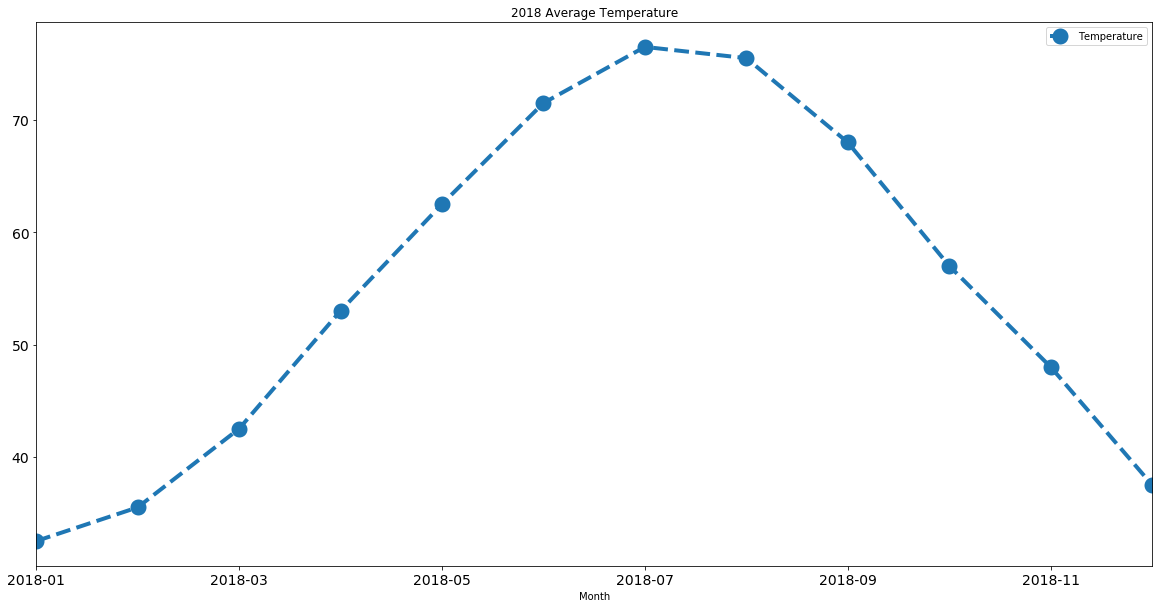

In [15]:
# Create a monthly temperature dictionary, data otained from google.
# probably need to find a way to get daily temperature in order to do more 
# in depth analysis and build a regression model.
temperature_dict = {
    'Month':['2018-01', 
             '2018-02',
             '2018-03',
             '2018-04',
             '2018-05',
             '2018-06',
             '2018-07',
             '2018-08',
             '2018-09',
             '2018-10',
             '2018-11',
             '2018-12'],
    'Temperature':[32.5, 35.5, 42.5, 53, 62.5, 71.5, 76.5, 75.5, 68, 57, 48, 37.5]
}

# Create a dataframe using the dictionary data
temperature_df = pd.DataFrame.from_dict(temperature_dict)

# Rename the columns properly
temperature_df = temperature_df.rename(index=str, columns={"Month": "Month", "Temperature": "Temperature"})

# Learned how to add x & y axis label
temperature_df.plot(
    x = 'Month',
    y = 'Temperature',
    figsize = (20,10), 
    kind = 'line',
    title = '2018 Average Temperature',
    fontsize = 14,
    linewidth = 4.0, 
    markeredgewidth = 10.0,
    linestyle = '--', 
    marker = 'o',
    rot = 0)

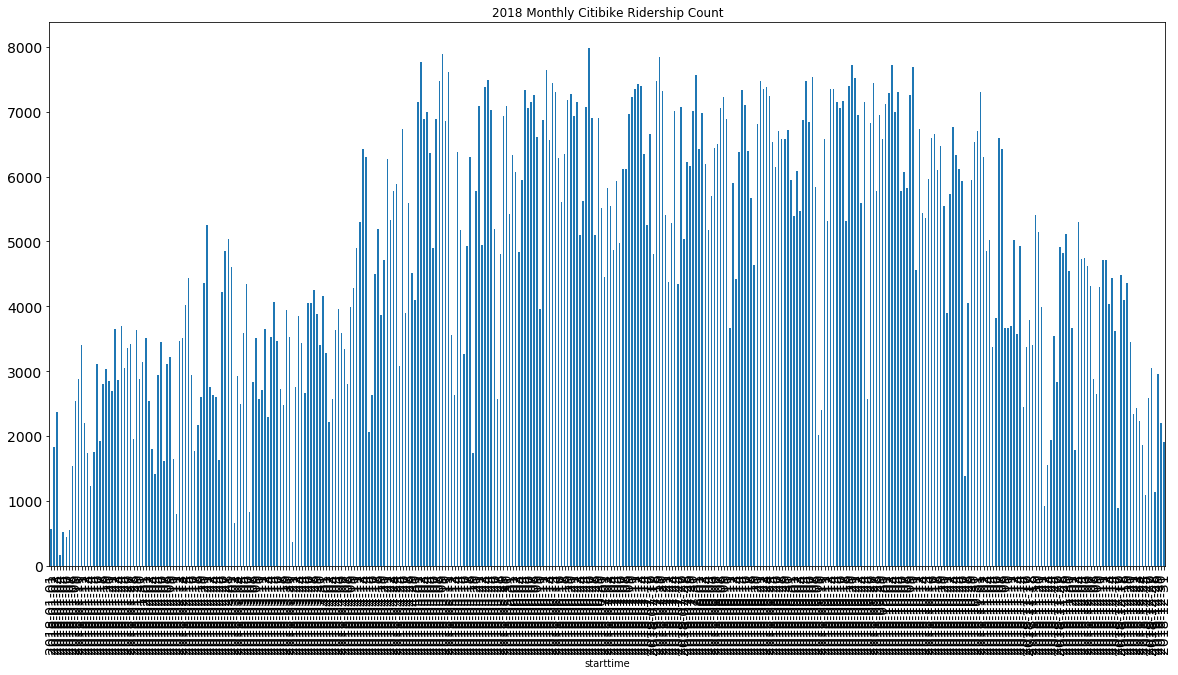

In [16]:
daily_answer.plot(
    figsize = (20,10),
    kind = 'bar',
    title = '2018 Monthly Citibike Ridership Count',
    fontsize = 14,
    legend=False)

# Question 02: Pending

In [17]:
# Enter Python & Pandas Code here :)

# Question 03: What is the most / least popular station?

In [18]:
# Most busy start station
# https://stackoverflow.com/q/29836477
# http://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
key = 'start station name'
start_station_df = citibike.groupby(key)[key].count().reset_index(name = 'count')
start_station_df.sort_values(by = 'count', ascending = False, inplace = True)

# The most popular start stations award goes to...
print('The most popular start station: ' + str(start_station_df.iloc[0][0]), end = '')
print(' ({:,} times)'.format(start_station_df.iloc[0][1]))

# Most busy end station
key = 'end station name'
end_station_df = citibike.groupby(key)[key].count().reset_index(name = 'count')
end_station_df.sort_values(by = 'count', ascending = False, inplace = True)

print('The most popular end station:   ' + str(end_station_df.iloc[0][0]), end = '')
print(' ({:,} times)'.format(end_station_df.iloc[0][1]))

# Some information about this station
print('\nFrom Wiki: Pershing Square is a public square in Manhattan, New York City. ')
print('Located where Park Avenue and 42nd Street intersect in front of Grand Central Terminal.')
print('The main roadway of Park Avenue crosses over 42nd Street on the Park Avenue Viaduct. ')
print('It is also known as the Pershing Square Viaduct.')

# Top 10 one way direction...
# Chart Annual rider vs. Weekly rider vs. Single rider

# School station analysis (Where do they go?)
# Male and Female trips
# Age Group

# Longest trip (Distance formula)
# Shortest trip (Distance formula)
# Holiday trip (Federal Holiday)

The most popular start station: Pershing Square North (14,856 times)
The most popular end station:   Pershing Square North (14,903 times)

From Wiki: Pershing Square is a public square in Manhattan, New York City. 
Located where Park Avenue and 42nd Street intersect in front of Grand Central Terminal.
The main roadway of Park Avenue crosses over 42nd Street on the Park Avenue Viaduct. 
It is also known as the Pershing Square Viaduct.


In [19]:
# https://stackoverflow.com/q/54009788
# This analysis exclude the trip where they start and end at the same station
# Because it is actually central park, I am guessing for tourist?

# Do not want the trip start and end at the same place
citibike_trip = citibike[citibike['start station name'] != citibike['end station name']]

# Create a subset dataframe with only start & end station name
citibike_trip = citibike_trip.filter(['start station name', 'end station name'])

# Create the trip string
citibike_trip['trip'] = citibike_trip['start station name'] + ' to ' + citibike_trip['end station name']

# Group by trip and add count column
trip_df = citibike_trip.groupby('trip')['trip'].count().reset_index(name = 'count')
trip_df.sort_values(by = 'count', ascending = False, inplace = True)

# Print out the result
print('The most popular ride is : ' + trip_df.iloc[0][0], end = '')
print(' ({} times)'.format(trip_df.iloc[0][1]))
print('The least popular ride is: ' + trip_df.iloc[-1][0], end = '')
print(' ({} times)'.format(trip_df.iloc[-1][1]))

The most popular ride is : E 7 St & Avenue A to Cooper Square & Astor Pl (777 times)
The least popular ride is: old - E 13 St & Avenue A to Watts St & Greenwich St (1 times)


# Top 10 poupar trips in 2018

In [20]:
# Take a look at the top 10 popular trips
trip_df.head(10)

,trip,count
88553,E 7 St & Avenue A to Cooper Square & Astor Pl,777
46784,Central Park S & 6 Ave to 5 Ave & E 88 St,619
146951,S 4 St & Wythe Ave to N 6 St & Bedford Ave,556
133299,N 6 St & Bedford Ave to S 4 St & Wythe Ave,520
167467,W 21 St & 6 Ave to 9 Ave & W 22 St,482
139065,Pershing Square North to W 33 St & 7 Ave,455
138799,Pershing Square North to E 24 St & Park Ave S,453
138701,Pershing Square North to Broadway & W 32 St,446
59051,DeKalb Ave & Vanderbilt Ave to DeKalb Ave & Hu...,426
5297,12 Ave & W 40 St to West St & Chambers St,421


# What are the type of membership (Annual members or paid per ride?)

In [21]:
membership_df = citibike.groupby('usertype')['usertype'].count()
membership_df = membership_df.reset_index(name = 'count')
membership_df = membership_df.set_index(['usertype'])

# Set the index so it will print properly
membership_df

,count
usertype,
Customer,193728
Subscriber,1560829


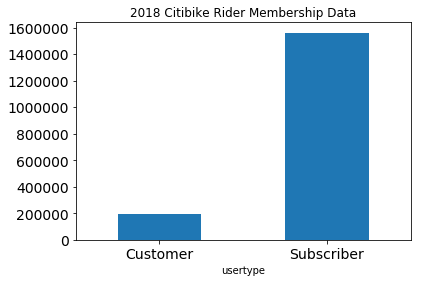

In [22]:
# Reference: https://markhneedham.com/blog/2018/09/18/matplotlib-remove-axis-legend/
membership_df.plot(
    title = '2018 Citibike Rider Membership Data', 
    fontsize = 14,
    kind = 'bar',
    rot = 0,
    legend = None)

In [23]:
gender_df = citibike.groupby('gender')['gender'].count()
gender_df = gender_df.reset_index(name = 'count')
gender_df = gender_df.set_index(['gender'])

# Set the index so it will print properly
gender_df

,count
gender,
0,148466
1,1197157
2,408934


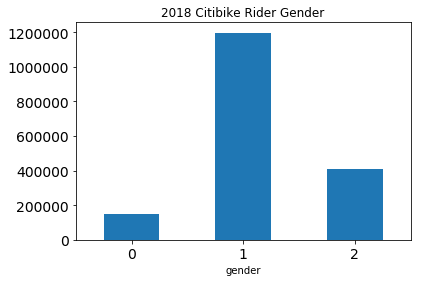

In [24]:
# Reference: https://markhneedham.com/blog/2018/09/18/matplotlib-remove-axis-legend/
gender_df.plot(
    title = '2018 Citibike Rider Gender',
    fontsize = 14,
    kind = 'bar',
    rot = 0,
    legend = None)

In [25]:
# Age Group
# https://stackoverflow.com/a/34683105
age_df = citibike[['birth year']].copy()

# Replace the column names
age_df.columns = age_df.columns.str.strip().str.lower().str.replace(' ', '_')

# Failed attempt...
# age_df['age'] = age_df.apply(lambda row: row['birth_year'])

def get_age(year_of_birth):
    result = 2019 - int(year_of_birth)
    if result >= 0 and result <=80 and result != 50:
        return result
    else:
        return -1

# Calculate a new column by using vectorize method
age_df['age'] = np.vectorize(get_age)(age_df['birth_year'])

age_df = age_df[age_df['age'] != -1]

age_plot_df = age_df.groupby('age')['age'].count()
age_plot_df = age_plot_df.reset_index(name = 'count')
age_plot_df = age_plot_df.set_index(['age'])

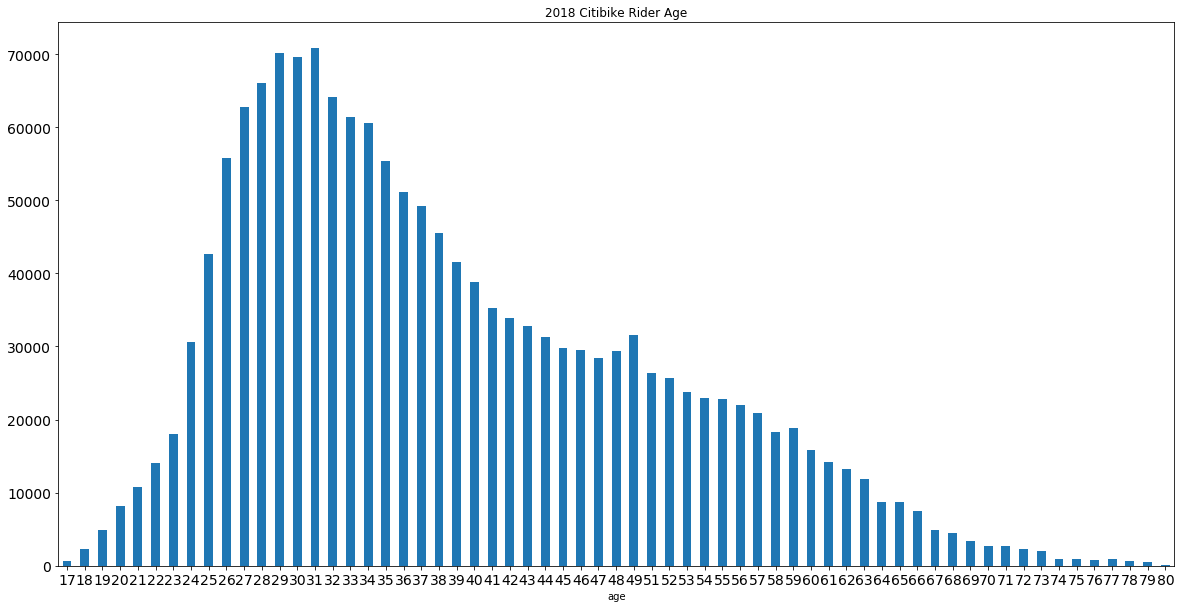

In [26]:
age_plot_df.plot(
    figsize = (20,10), 
    title = '2018 Citibike Rider Age', 
    fontsize = 14,
    kind = 'bar',
    rot = 0,
    legend = None)

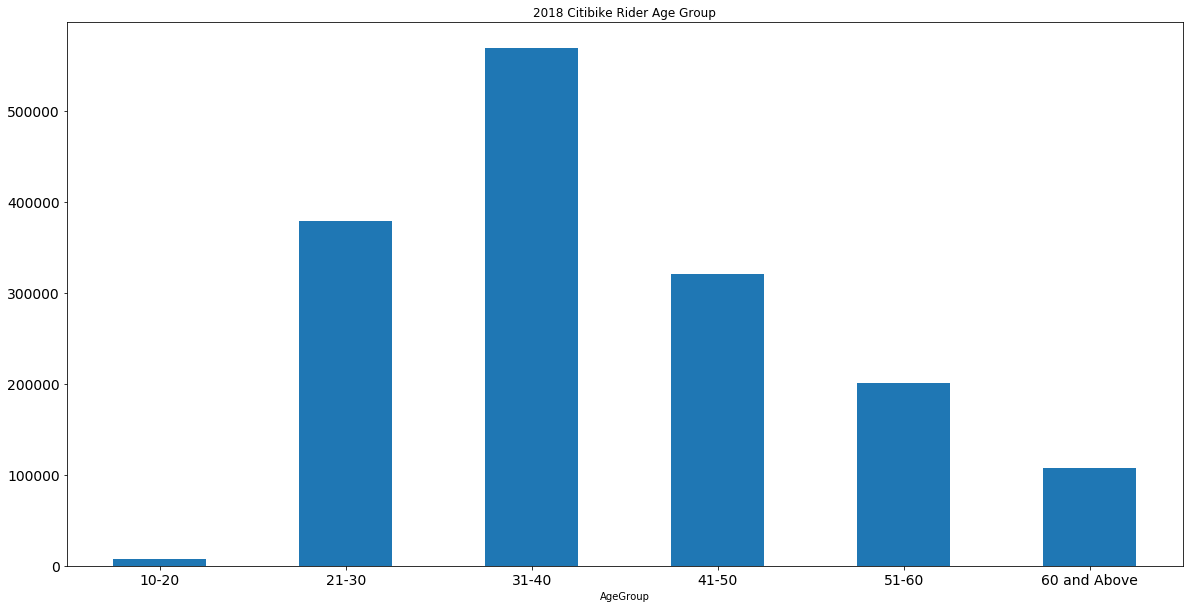

In [27]:
# bins = [0, 24, 59, 999]
# labels = ['Student <=24','Adult','Senior Adult']

bins = [0, 20, 30, 40, 50, 60, 100]
labels = ['10-20', '21-30', '31-40', '41-50', '51-60', '60 and Above']

age_df['AgeGroup'] = pd.cut(age_df['age'], bins=bins, labels=labels, right=False)

agegroup_plot_df = age_df.groupby('AgeGroup')['AgeGroup'].count()
agegroup_plot_df = agegroup_plot_df.reset_index(name = 'count')
agegroup_plot_df = agegroup_plot_df.set_index(['AgeGroup'])

agegroup_plot_df.plot(
    figsize = (20,10), 
    title = '2018 Citibike Rider Age Group', 
    fontsize = 14,
    kind = 'bar',
    rot = 0,
    legend = None)

In [28]:
gender_df = citibike.groupby('gender')['gender'].count()
gender_df = gender_df.reset_index(name = 'count')
gender_df = gender_df.set_index(['gender'])

# Set the index so it will print properly
gender_df

,count
gender,
0,148466
1,1197157
2,408934


In [29]:
# https://stackoverflow.com/a/43211266
from math import sin, cos, sqrt, atan2, radians


def get_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in miles 
    R = 3958.8

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

def get_duration(datetime1, datetime2):
    # https://stackoverflow.com/a/14920923
    duration = datetime2 - datetime1
    return duration.total_seconds()
    
def get_speed(distance, duration):
    hour = 60.0 * 60.0 * 60.0 / (seconds)
    
    # return distance per hour
    return (distance/hour)

ans = get_distance(40.729538, -73.984267, 40.736197, -74.008592)
ans = get_distance(40.730260, -73.953940, 40.729060, -73.957790)

print("Result:", ans)

Result: 0.21796866823983926


In [30]:
import numpy as np

df = citibike.sample(frac = 0.1, replace = True, random_state = 1)

# Vectorize: https://stackoverflow.com/q/19914937
# start station latitude, start station longitude
df['distance'] = np.vectorize(get_distance)(df['start station latitude'],
                                     df['start station longitude'],
                                     df['end station latitude'],
                                     df['end station longitude'])



# df['duration'] = np.vectorize(get_duration)(df['starttime'], df['stoptime'])
# df['C'] = (df['B'] - df['A'])/ np.timedelta64(1, 's')
df['duration'] = (df['stoptime'] - df['starttime']) / np.timedelta64(1, 's')

df['speed'] = (df['distance'] / ((60.0 * 60.0) / df['duration']))

# citibike_trip = citibike[citibike['start station name'] != citibike['end station name']]
commute_trip = df[df['start station name'] != df['end station name']]

# Limit the ride that is slower than walking and within reason (race bike...)
commute_trip = commute_trip[(commute_trip['speed'] >= 3.5)
                            & (commute_trip['speed'] <= 25)]

# commute_trip = commute_trip[commute_trip['birth year'] >= 1989]

'''
Speeds above 16 mph are considered very vigorous while riding a bicycle. 
A light pace would be 10 to 11.9 mph while a moderate pace is categorized as 12 to 13.9 mph. 
If you are a beginner, start at a light or moderate pace and ride at speeds between 10 and 14 mph.
'''

speed_bins = [0, 9, 12, 15, 99]
speed_labels = ['Leisurely (< 9 MPH)', 'Fast MPH (9 - 11.9 MPH)', 'Moderate (12 - 14.9 MPH)', 'Vigorous (15 MPH+)']

commute_trip['SpeedGroup'] = pd.cut(commute_trip['speed'], bins=speed_bins, labels=speed_labels, right=False)

# To do: Look up scientific information about age group/ speed.

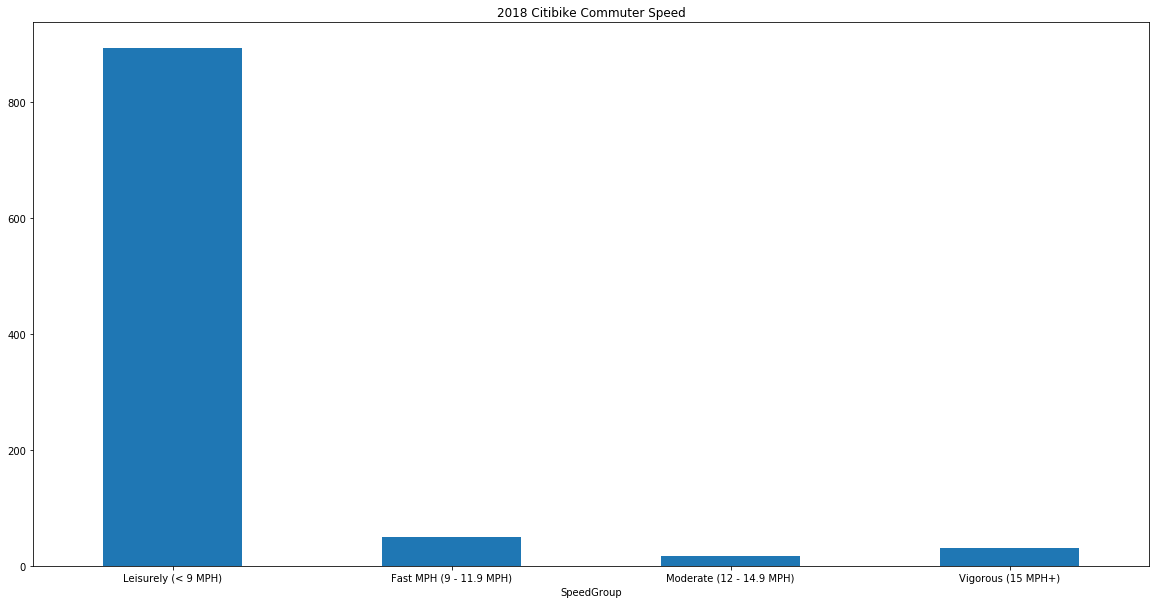

In [31]:
commute_trip_plot = commute_trip.groupby('SpeedGroup')['SpeedGroup'].count()
commute_trip_plot = commute_trip_plot.reset_index(name = 'count')
commute_trip_plot = commute_trip_plot.set_index(['SpeedGroup'])

commute_trip_plot.plot(
    figsize = (20,10), 
    title = '2018 Citibike Commuter Speed', 
    kind = 'bar',
    rot = 0,
    legend = None)

# Question 4: Advanced commuting analysis

In [32]:
# Example of connected trip.
# Same gender and year of birth started in the same station within 5 minutes.

# Example of regular commuter rides
# Start and end station by the same user?
# Morning starting on the train station and ending on the same station

# Year of Birth & Gender (Start time and station)
# Working age adult: 7am-9am trips, where they do they go to work at?

In [33]:
# Helper function to determine if datetime is between a time
def check_commute_hour(my_hour):
    if (my_hour >= 6 and my_hour <= 10):
        return 'Morning'
    elif (my_hour >= 16 and my_hour <= 21):
        return 'Evening'
    else:
        return 'Other'

# Morning Ride (6am-10am)
commute_df = citibike[['tripduration', 'starttime', 
                       'start station name', 'end station name', 
                       'usertype', 'birth year', 'gender']].copy()

commute_df = commute_df.loc[commute_df['usertype'] == 'Subscriber']

In [34]:
# Set a True or False Flag between 6am-10am (24 hour time format)
# Link: https://stackoverflow.com/a/45564365
# Super helpful trick to get the dt.hour (hour portion)
commute_df['commute_type'] = np.vectorize(check_commute_hour)(commute_df['starttime'].dt.hour)
commute_df['date'] = commute_df['starttime'].dt.date

commute_df = commute_df.loc[commute_df['commute_type'] != 'Other']

# Exclude daily ride, unknown gender and unknow age
# How to filter by values: https://stackoverflow.com/a/17071908
# df.loc[df['column_name'] == some_value]
morning_commute_df = commute_df.loc[commute_df['commute_type'] == 'Morning']
evening_commute_df = commute_df.loc[commute_df['commute_type'] == 'Evening']

In [35]:
# Create a Ukey to join easier
morning_commute_df['Ukey'] = (morning_commute_df['usertype'] + '-' + 
                     morning_commute_df['birth year'].map(str) + '-' + 
                     morning_commute_df['gender'].map(str) + '-' + 
                     morning_commute_df['date'].map(str) + '-' +
                     morning_commute_df['start station name'] + '-' +
                     morning_commute_df['end station name'])

evening_commute_df['Ukey'] = (evening_commute_df['usertype'] + '-' + 
                     evening_commute_df['birth year'].map(str) + '-' + 
                     evening_commute_df['gender'].map(str) + '-' + 
                     evening_commute_df['date'].map(str) + '-' +
                     evening_commute_df['end station name'] + '-' +
                     evening_commute_df['start station name'])

# Index by Ukey
morning_commute_df = morning_commute_df.set_index('Ukey')
evening_commute_df = evening_commute_df.set_index('Ukey')

/Users/Study/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/Study/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [41]:
# How to get dataframe column and types
# morning_df['starttime'].dtype << Just 1 column
# https://stackoverflow.com/a/43852726
print(type(morning_commute_df))
print(morning_commute_df.dtypes)
morning_commute_df.head(5)

<class 'pandas.core.frame.DataFrame'>
tripduration                   int64
starttime             datetime64[ns]
start station name            object
end station name              object
usertype                      object
birth year                     int64
gender                         int64
commute_type                  object
date                          object
dtype: object


,tripduration,starttime,start station name,end station name,usertype,birth year,gender,commute_type,date
Ukey,,,,,,,,,
Subscriber-1989-1-2018-01-18-Greenpoint Ave & Manhattan Ave-Milton St & Franklin St,126,2018-01-18 09:31:57.538,Greenpoint Ave & Manhattan Ave,Milton St & Franklin St,Subscriber,1989,1,Morning,2018-01-18
Subscriber-1985-1-2018-01-16-E 6 St & Avenue B-Lafayette St & E 8 St,340,2018-01-16 07:24:13.551,E 6 St & Avenue B,Lafayette St & E 8 St,Subscriber,1985,1,Morning,2018-01-16
Subscriber-1962-1-2018-01-13-W 59 St & 10 Ave-W 31 St & 7 Ave,790,2018-01-13 08:49:22.410,W 59 St & 10 Ave,W 31 St & 7 Ave,Subscriber,1962,1,Morning,2018-01-13
Subscriber-1991-1-2018-01-31-E 39 St & 3 Ave-Broadway & W 41 St,360,2018-01-31 08:50:10.374,E 39 St & 3 Ave,Broadway & W 41 St,Subscriber,1991,1,Morning,2018-01-31
Subscriber-1989-2-2018-01-25-Grand Ave & Bergen St-Park Pl & Vanderbilt Ave,321,2018-01-25 08:16:50.244,Grand Ave & Bergen St,Park Pl & Vanderbilt Ave,Subscriber,1989,2,Morning,2018-01-25


In [37]:
# Join the two dataframe to get continued trip (need them to the same date)
round_trip_df = morning_commute_df.join(evening_commute_df, how='inner', on='Ukey', lsuffix='', rsuffix='_right')

In [38]:
# Round trip dataframe! :)
round_trip_df = round_trip_df.sort_values(by ='date')

In [39]:
# Next question is how to show it on google map?
round_trip_view_df = round_trip_df.drop(
    ['usertype_right', 'birth year_right', 'gender_right','date_right'] 
    , axis=1)

round_trip_view_df = round_trip_view_df.loc[round_trip_view_df['tripduration'] >= 600]
round_trip_view_df = round_trip_view_df.sort_values('date')

In [40]:
# DataFrame.drop_duplicates
round_trip_df = round_trip_df.drop_duplicates()
round_trip_df.shape

(3277, 18)